# 맨해튼의 에어비앤비 예약률 영향 요인 분석
## 데이터 분석 프로젝트
2015313501 유선우

In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd

# used for dates
import datetime
from datetime import datetime, date, time

# Set some pandas options controlling output format
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 100)

# bring in matplotlib for graphics
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

## csv 파일 불러오기

In [2]:
listings = pd.read_csv('../data/project/listings.csv', 
                       usecols=[0,19,22,28,32,34,36,48,49,52,60,64,80,82,86,96,98],
                      parse_dates=['host_since'])
listings[:5]

     id  host_id host_since host_is_superhost  host_listings_count  \
0  3647     4632 2008-11-25                 f                  1.0   
1  3831     4869 2008-12-07                 f                  1.0   
2  5022     7192 2009-01-29                 f                  1.0   
3  5099     7322 2009-02-02                 f                  1.0   
4  5121     7356 2009-02-03                 f                  1.0   

                                  host_verifications host_identity_verified  latitude  longitude  \
0  ['email', 'phone', 'google', 'reviews', 'jumio...                      t  40.80902  -73.94190   
1               ['email', 'phone', 'reviews', 'kba']                      t  40.68514  -73.95976   
2   ['email', 'phone', 'facebook', 'reviews', 'kba']                      t  40.79851  -73.94399   
3  ['email', 'phone', 'reviews', 'jumio', 'govern...                      f  40.74767  -73.97500   
4  ['email', 'phone', 'facebook', 'reviews', 'off...                      f  40

In [3]:
# 열과 행의 개수 확인
listings.shape

(48377, 17)

In [4]:
# 열 이름 확인
listings.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost', 'host_listings_count',
       'host_verifications', 'host_identity_verified', 'latitude', 'longitude', 'room_type',
       'price', 'cleaning_fee', 'availability_365', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'cancellation_policy'],
      dtype='object')

출처: insideairbnb.com
수집 날짜: 2019.09.12

## null 값 확인

In [5]:
listings.isnull().sum()

id                            0
host_id                       0
host_since                   21
host_is_superhost            21
host_listings_count          21
host_verifications            0
host_identity_verified       21
latitude                      0
longitude                     0
room_type                     0
price                         0
cleaning_fee              10234
availability_365              0
number_of_reviews             0
review_scores_rating      10561
instant_bookable              0
cancellation_policy           0
dtype: int64

## 변수 생성 및 수정

### 1. host_age : 데이터 수집 날짜 - 호스트의 가입 일자(host_since)
host_since의 null값은 대체하지 않음

In [7]:
s = pd.to_datetime(date(2019,9,12))
td = pd.Series(s - listings.host_since.dt.to_pydatetime())
dftd = pd.DataFrame({'host_age':td})
listings = pd.concat([listings, dftd], axis=1)
listings.host_age = listings.host_age.dt.days
listings.head()

     id  host_id host_since host_is_superhost  host_listings_count  \
0  3647     4632 2008-11-25                 f                  1.0   
1  3831     4869 2008-12-07                 f                  1.0   
2  5022     7192 2009-01-29                 f                  1.0   
3  5099     7322 2009-02-02                 f                  1.0   
4  5121     7356 2009-02-03                 f                  1.0   

                                  host_verifications host_identity_verified  latitude  longitude  \
0  ['email', 'phone', 'google', 'reviews', 'jumio...                      t  40.80902  -73.94190   
1               ['email', 'phone', 'reviews', 'kba']                      t  40.68514  -73.95976   
2   ['email', 'phone', 'facebook', 'reviews', 'kba']                      t  40.79851  -73.94399   
3  ['email', 'phone', 'reviews', 'jumio', 'govern...                      f  40.74767  -73.97500   
4  ['email', 'phone', 'facebook', 'reviews', 'off...                      f  40

In [8]:
# 필요없는 행 삭제
del listings['host_since']

### 2. host_is_superhost : 더미 변수화
category형 value를 가진 변수를 회귀분석에 넣기 위해서 0,1로 표시해야 함

In [9]:
listings.host_is_superhost.head()

0    f
1    f
2    f
3    f
4    f
Name: host_is_superhost, dtype: object

In [10]:
listings = pd.get_dummies(listings, columns=['host_is_superhost'], prefix='superhost')
listings.head()

     id  host_id  host_listings_count                                 host_verifications  \
0  3647     4632                  1.0  ['email', 'phone', 'google', 'reviews', 'jumio...   
1  3831     4869                  1.0               ['email', 'phone', 'reviews', 'kba']   
2  5022     7192                  1.0   ['email', 'phone', 'facebook', 'reviews', 'kba']   
3  5099     7322                  1.0  ['email', 'phone', 'reviews', 'jumio', 'govern...   
4  5121     7356                  1.0  ['email', 'phone', 'facebook', 'reviews', 'off...   

  host_identity_verified  latitude  longitude        room_type    price cleaning_fee  \
0                      t  40.80902  -73.94190     Private room  $150.00       $75.00   
1                      t  40.68514  -73.95976  Entire home/apt   $89.00          NaN   
2                      t  40.79851  -73.94399  Entire home/apt   $80.00       $80.00   
3                      f  40.74767  -73.97500  Entire home/apt  $200.00      $125.00   
4      

In [44]:
listings.head()

     id  host_id  host_listings_count                                 host_verifications  \
0  3647     4632                  1.0  ['email', 'phone', 'google', 'reviews', 'jumio...   
1  3831     4869                  1.0               ['email', 'phone', 'reviews', 'kba']   
2  5022     7192                  1.0   ['email', 'phone', 'facebook', 'reviews', 'kba']   
3  5099     7322                  1.0  ['email', 'phone', 'reviews', 'jumio', 'govern...   
4  5121     7356                  1.0  ['email', 'phone', 'facebook', 'reviews', 'off...   

  host_identity_verified  latitude  longitude        room_type    price cleaning_fee  \
0                      t  40.80902  -73.94190     Private room  $150.00       $75.00   
1                      t  40.68514  -73.95976  Entire home/apt   $89.00          NaN   
2                      t  40.79851  -73.94399  Entire home/apt   $80.00       $80.00   
3                      f  40.74767  -73.97500  Entire home/apt  $200.00      $125.00   
4      

### 3. host_listings_count : null값을 1로 대체
mean은 outlier에 민감하기 때문에 중위값인 median으로 대체

In [14]:
listings.host_listings_count.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: host_listings_count, dtype: float64

In [15]:
listings.host_listings_count.median()

1.0

In [16]:
listings.host_listings_count[listings.host_listings_count.isnull()] = 1.0
listings.host_listings_count.isnull().sum()

C:\Users\Sunwoo Yu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0

### 4. host_identity_verified : null값을 host_verifications 변수를 통해 검증한 후 적절한 t/f로 대체 - 이후 더미변수화
host_identity_verified가 null인 관측치는 host_verifications가 None으로 나타남. 전혀 인증을 하지 않았다고 판명한 후 'f'로 대체. 이후 더미변수화

In [17]:
listings.host_verifications.head()

0    ['email', 'phone', 'google', 'reviews', 'jumio...
1                 ['email', 'phone', 'reviews', 'kba']
2     ['email', 'phone', 'facebook', 'reviews', 'kba']
3    ['email', 'phone', 'reviews', 'jumio', 'govern...
4    ['email', 'phone', 'facebook', 'reviews', 'off...
Name: host_verifications, dtype: object

In [18]:
listings.host_identity_verified.head()

0    t
1    t
2    t
3    f
4    f
Name: host_identity_verified, dtype: object

In [19]:
listings.host_verifications[listings.host_identity_verified.isnull()]

224      None
773      None
5426     None
5807     None
6286     None
7816     None
7893     None
8731     None
9387     None
14144    None
         ... 
32297    None
34727    None
36900    None
37577    None
38222    None
40045    None
40768    None
44447    None
45400    None
45648    None
Name: host_verifications, Length: 21, dtype: object

In [20]:
listings.host_identity_verified[listings.host_identity_verified.isnull()] = 'f'
listings.host_identity_verified.isnull().sum()

C:\Users\Sunwoo Yu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0

In [21]:
listings = pd.get_dummies(listings, columns=['host_identity_verified'], prefix='id_verified')
listings.head()

     id  host_id  host_listings_count                                 host_verifications  \
0  3647     4632                  1.0  ['email', 'phone', 'google', 'reviews', 'jumio...   
1  3831     4869                  1.0               ['email', 'phone', 'reviews', 'kba']   
2  5022     7192                  1.0   ['email', 'phone', 'facebook', 'reviews', 'kba']   
3  5099     7322                  1.0  ['email', 'phone', 'reviews', 'jumio', 'govern...   
4  5121     7356                  1.0  ['email', 'phone', 'facebook', 'reviews', 'off...   

   latitude  longitude        room_type    price cleaning_fee  availability_365  \
0  40.80902  -73.94190     Private room  $150.00       $75.00               365   
1  40.68514  -73.95976  Entire home/apt   $89.00          NaN               192   
2  40.79851  -73.94399  Entire home/apt   $80.00       $80.00                 0   
3  40.74767  -73.97500  Entire home/apt  $200.00      $125.00                13   
4  40.68688  -73.95596     Priva

In [22]:
# 필요없는 열 삭제
del listings['host_verifications']
listings.head()

     id  host_id  host_listings_count  latitude  longitude        room_type    price cleaning_fee  \
0  3647     4632                  1.0  40.80902  -73.94190     Private room  $150.00       $75.00   
1  3831     4869                  1.0  40.68514  -73.95976  Entire home/apt   $89.00          NaN   
2  5022     7192                  1.0  40.79851  -73.94399  Entire home/apt   $80.00       $80.00   
3  5099     7322                  1.0  40.74767  -73.97500  Entire home/apt  $200.00      $125.00   
4  5121     7356                  1.0  40.68688  -73.95596     Private room   $60.00        $0.00   

   availability_365  number_of_reviews  review_scores_rating instant_bookable  \
0               365                  0                   NaN                f   
1               192                279                  90.0                f   
2                 0                  9                  93.0                f   
3                13                 75                  89.0         

### 5. room_type : value의 category 수 만큼 column을 생성하여 더미 변수화
regression model을 구축할 때는 4개중 3개의 column만 사용

In [23]:
listings = pd.get_dummies(listings, columns=['room_type'], prefix='room')
listings.head()

     id  host_id  host_listings_count  latitude  longitude    price cleaning_fee  \
0  3647     4632                  1.0  40.80902  -73.94190  $150.00       $75.00   
1  3831     4869                  1.0  40.68514  -73.95976   $89.00          NaN   
2  5022     7192                  1.0  40.79851  -73.94399   $80.00       $80.00   
3  5099     7322                  1.0  40.74767  -73.97500  $200.00      $125.00   
4  5121     7356                  1.0  40.68688  -73.95596   $60.00        $0.00   

   availability_365  number_of_reviews  review_scores_rating  ...          cancellation_policy  \
0               365                  0                   NaN  ...  strict_14_with_grace_period   
1               192                279                  90.0  ...                     moderate   
2                 0                  9                  93.0  ...  strict_14_with_grace_period   
3                13                 75                  89.0  ...                     moderate   
4    

#### 띄어쓰기가 포함되지 않게 column명 변경

In [25]:
listings.rename(columns={'room_Entire home/apt':'Entire_home/apt','room_Hotel room':'Hotel_room','room_Private room':'Private_room','room_Shared room':'Shared_room'}, inplace=True)
listings.columns

Index(['id', 'host_id', 'host_listings_count', 'latitude', 'longitude', 'price', 'cleaning_fee',
       'availability_365', 'number_of_reviews', 'review_scores_rating', 'instant_bookable',
       'cancellation_policy', 'host_age', 'superhost_f', 'superhost_t', 'id_verified_f',
       'id_verified_t', 'Entire_home/apt', 'Hotel_room', 'Private_room', 'Shared_room'],
      dtype='object')

### 6. new_price : price + cleaning_fee

In [26]:
# 기존 price 변수는 $100.00과 같은 형식으로 표기되어있어 계산을 위해 int타입으로 바꾸어주어야 함
# 특수문자 제거
listings.price = listings.price.replace('\$','',regex=True)
listings.price = listings.price.replace('\.00','',regex=True)
listings.price = listings.price.replace('\,','',regex=True)
listings.price.head()

0    150
1     89
2     80
3    200
4     60
Name: price, dtype: object

In [27]:
# int타입으로 변경
listings.price = listings.price.astype('int')
listings.price.head()

0    150
1     89
2     80
3    200
4     60
Name: price, dtype: int32

#### cleaning_fee의 null값은 0으로 대체
cleaning_fee가 호스팅 시 필수 입력항목이 아닌만큼, null값이 나타난 이유는 cleaning fee가 존재하지 않아서라고 판명

In [28]:
listings.cleaning_fee[listings.cleaning_fee.isnull()] = 0
listings.cleaning_fee.isnull().sum()

C:\Users\Sunwoo Yu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0

In [29]:
# 특수문자 제거
listings.cleaning_fee = listings.cleaning_fee.replace('\$','',regex=True)
listings.cleaning_fee = listings.cleaning_fee.replace('\.00','',regex=True)
listings.cleaning_fee = listings.cleaning_fee.replace('\,','',regex=True)
listings.cleaning_fee.head()

0     75
1      0
2     80
3    125
4      0
Name: cleaning_fee, dtype: object

In [30]:
# int타입으로 변환
listings.cleaning_fee = listings.cleaning_fee.astype('int')
listings.cleaning_fee.head()

0     75
1      0
2     80
3    125
4      0
Name: cleaning_fee, dtype: int32

In [31]:
# new_price 변수 생성
np = listings.price + listings.cleaning_fee
dfnp = pd.DataFrame({'new_price':np})
listings = pd.concat([listings, dfnp], axis=1)
listings.head()

     id  host_id  host_listings_count  latitude  longitude  price  cleaning_fee  availability_365  \
0  3647     4632                  1.0  40.80902  -73.94190    150            75               365   
1  3831     4869                  1.0  40.68514  -73.95976     89             0               192   
2  5022     7192                  1.0  40.79851  -73.94399     80            80                 0   
3  5099     7322                  1.0  40.74767  -73.97500    200           125                13   
4  5121     7356                  1.0  40.68688  -73.95596     60             0                 0   

   number_of_reviews  review_scores_rating  ... host_age superhost_f  superhost_t  id_verified_f  \
0                  0                   NaN  ...   3943.0           1            0              0   
1                279                  90.0  ...   3931.0           1            0              0   
2                  9                  93.0  ...   3878.0           1            0            

In [32]:
# 필요없는 열 삭제
del listings['price']
del listings['cleaning_fee']

### 7. number_of_reviews

In [33]:
listings.number_of_reviews.head()

0      0
1    279
2      9
3     75
4     49
Name: number_of_reviews, dtype: int64

### 8. review_scores_rating : 결측치가 많아서 분포를 보고 대체 방법을 결정하기로 함

In [34]:
listings.review_scores_rating.head()

0     NaN
1    90.0
2    93.0
3    89.0
4    90.0
Name: review_scores_rating, dtype: float64

### 9. instant_bookable : 더미변수화

In [35]:
listings = pd.get_dummies(listings, columns=['instant_bookable'], prefix='instant_bookable')
listings.head()

     id  host_id  host_listings_count  latitude  longitude  availability_365  number_of_reviews  \
0  3647     4632                  1.0  40.80902  -73.94190               365                  0   
1  3831     4869                  1.0  40.68514  -73.95976               192                279   
2  5022     7192                  1.0  40.79851  -73.94399                 0                  9   
3  5099     7322                  1.0  40.74767  -73.97500                13                 75   
4  5121     7356                  1.0  40.68688  -73.95596                 0                 49   

   review_scores_rating          cancellation_policy  host_age  ...  superhost_t  id_verified_f  \
0                   NaN  strict_14_with_grace_period    3943.0  ...            0              0   
1                  90.0                     moderate    3931.0  ...            0              0   
2                  93.0  strict_14_with_grace_period    3878.0  ...            0              0   
3        

### 10. cancellation_policy : 더미변수화 

In [36]:
listings = pd.get_dummies(listings, columns=['cancellation_policy'], prefix='cancel')
listings.head()

     id  host_id  host_listings_count  latitude  longitude  availability_365  number_of_reviews  \
0  3647     4632                  1.0  40.80902  -73.94190               365                  0   
1  3831     4869                  1.0  40.68514  -73.95976               192                279   
2  5022     7192                  1.0  40.79851  -73.94399                 0                  9   
3  5099     7322                  1.0  40.74767  -73.97500                13                 75   
4  5121     7356                  1.0  40.68688  -73.95596                 0                 49   

   review_scores_rating  host_age  superhost_f  ...  Shared_room  new_price  instant_bookable_f  \
0                   NaN    3943.0            1  ...            0        225                   1   
1                  90.0    3931.0            1  ...            0         89                   1   
2                  93.0    3878.0            1  ...            0        160                   1   
3        

In [66]:
listings.columns

Index(['id', 'host_id', 'host_listings_count', 'latitude', 'longitude', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'host_age', 'superhost_f', 'superhost_t',
       'id_verified_f', 'id_verified_t', 'Entire_home/apt', 'Hotel_room', 'Private_room',
       'Shared_room', 'new_price', 'instant_bookable_f', 'instant_bookable_t', 'cancel_flexible',
       'cancel_moderate', 'cancel_strict', 'cancel_strict_14_with_grace_period',
       'cancel_super_strict_30', 'cancel_super_strict_60'],
      dtype='object')

In [37]:
# null값 확인
listings.isnull().sum()

id                                        0
host_id                                   0
host_listings_count                       0
latitude                                  0
longitude                                 0
availability_365                          0
number_of_reviews                         0
review_scores_rating                  10561
host_age                                 21
superhost_f                               0
                                      ...  
Shared_room                               0
new_price                                 0
instant_bookable_f                        0
instant_bookable_t                        0
cancel_flexible                           0
cancel_moderate                           0
cancel_strict                             0
cancel_strict_14_with_grace_period        0
cancel_super_strict_30                    0
cancel_super_strict_60                    0
Length: 26, dtype: int64

## 데이터 선별
분석의 목적은 맨해튼 섬 내의 에어비앤비를 조사하는 것이나, 데이터셋에는 뉴욕시티의 모든 데이터가 담겨있어 위도와 경도를 기준으로 맨해튼 섬의 데이터만 선별

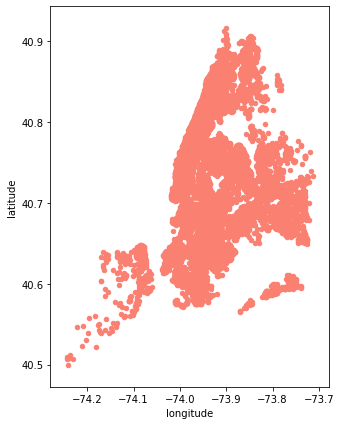

In [39]:
listings.plot.scatter(x='longitude', y='latitude', c='salmon', figsize=(5,7))

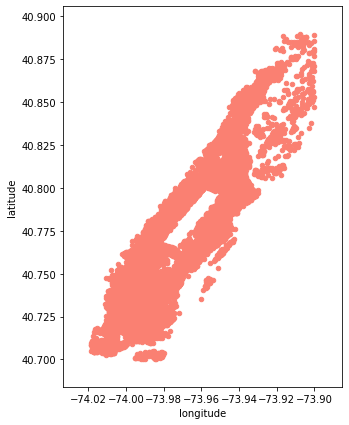

In [40]:
listings = listings[(listings.latitude>40.70) & (listings.longitude<-73.9) & (listings.latitude<40.9)]
listings = listings[listings.latitude>1.7*listings.longitude+166.468]
listings.plot.scatter(x='longitude',y='latitude', c='salmon', figsize=(5,7))

In [41]:
# 남은 행과 열의 개수
listings.shape

(21683, 26)

In [42]:
listings.isnull().sum()

id                                       0
host_id                                  0
host_listings_count                      0
latitude                                 0
longitude                                0
availability_365                         0
number_of_reviews                        0
review_scores_rating                  5427
host_age                                 7
superhost_f                              0
                                      ... 
Shared_room                              0
new_price                                0
instant_bookable_f                       0
instant_bookable_t                       0
cancel_flexible                          0
cancel_moderate                          0
cancel_strict                            0
cancel_strict_14_with_grace_period       0
cancel_super_strict_30                   0
cancel_super_strict_60                   0
Length: 26, dtype: int64

# 변수의 분포 확인

### 1. host_age

In [43]:
listings.host_age.describe()

count    21676.000000
mean      1559.561174
std        851.834311
min          1.000000
25%        957.000000
50%       1575.500000
75%       2167.250000
max       3970.000000
Name: host_age, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x27100107f98>,
 'caps': [<matplotlib.lines.Line2D at 0x27100116668>,
 'boxes': [<matplotlib.lines.Line2D at 0x27100107b70>],
 'medians': [<matplotlib.lines.Line2D at 0x27100116cf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x27100116da0>],
 'means': []}

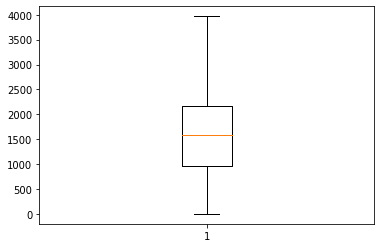

In [44]:
plt.boxplot(listings.host_age[listings.host_age.notnull()])

### 2. host_is_superhost

<BarContainer object of 2 artists>

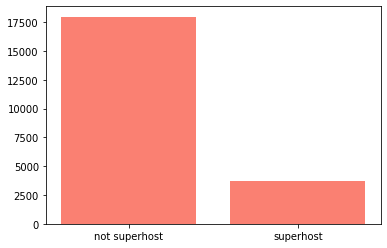

In [53]:
ind = ['not superhost','superhost']
hei = [listings.superhost_f.sum(),listings.superhost_t.sum()]
plt.bar(ind, hei,color='salmon')

### 3. host_listings_count

In [46]:
listings.host_listings_count.describe()

count    21683.000000
mean        33.169257
std        144.774532
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1611.000000
Name: host_listings_count, dtype: float64

### 4. id_verified

<BarContainer object of 2 artists>

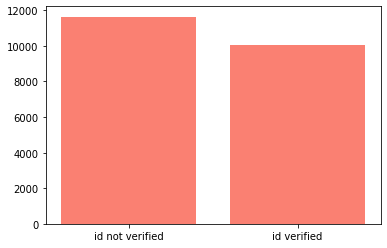

In [47]:
ind = ['id not verified','id verified']
hei = [listings.id_verified_f.sum(),listings.id_verified_t.sum()]
plt.bar(ind, hei, color='salmon')

### 5. room_type

<BarContainer object of 4 artists>

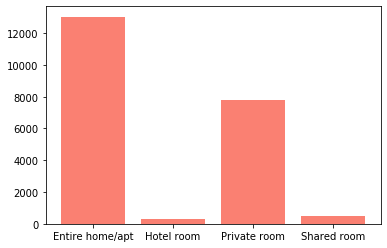

In [48]:
ind = ['Entire home/apt','Hotel room','Private room','Shared room']
hot = listings['Hotel_room'].sum()
prv = listings['Private_room'].sum()
shr = listings['Shared_room'].sum()
hei = [listings['Entire_home/apt'].sum(),hot,prv,shr] 
plt.bar(ind,hei, color='salmon')

(array([ 35.,   6.,   9.,  12.,   8.,   6.,   7.,  22.,  76., 151.]),
 array([  0. ,  36.5,  73. , 109.5, 146. , 182.5, 219. , 255.5, 292. ,
        328.5, 365. ]),
 <a list of 10 Patch objects>)

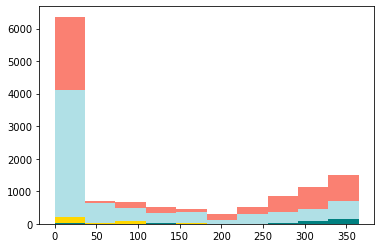

In [49]:
private = listings[listings['Private_room']==1]
entire = listings[listings['Entire_home/apt']==1]
hotel = listings[listings['Hotel_room']==1]
share = listings[listings['Shared_room']==1]
plt.hist(entire['availability_365'],color='salmon')
plt.hist(private['availability_365'],color='powderblue')
plt.hist(share['availability_365'],color='gold')
plt.hist(hotel['availability_365'],color='teal')

### 6. new_price

In [50]:
listings.new_price.describe()

count    21683.000000
mean       260.315501
std        345.134036
min          0.000000
25%        120.000000
50%        200.000000
75%        310.000000
max      10029.000000
Name: new_price, dtype: float64

In [51]:
# price가 0인 행 판별
listings[listings.new_price==0]

             id   host_id  host_listings_count  latitude  longitude  availability_365  \
24982  20933849  13709292                  2.0  40.75091  -73.97597                 0   

       number_of_reviews  review_scores_rating  host_age  superhost_f  ...  Shared_room  \
24982                  0                   NaN    1992.0            1  ...            0   

       new_price  instant_bookable_f  instant_bookable_t  cancel_flexible  cancel_moderate  \
24982          0                   1                   0                1                0   

       cancel_strict  cancel_strict_14_with_grace_period  cancel_super_strict_30  \
24982              0                                   0                       0   

       cancel_super_strict_60  
24982                       0  

[1 rows x 26 columns]

{'whiskers': [<matplotlib.lines.Line2D at 0x27101252470>,
 'caps': [<matplotlib.lines.Line2D at 0x27101252b00>,
 'boxes': [<matplotlib.lines.Line2D at 0x27101252080>],
 'medians': [<matplotlib.lines.Line2D at 0x27101252ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2710125c518>],
 'means': []}

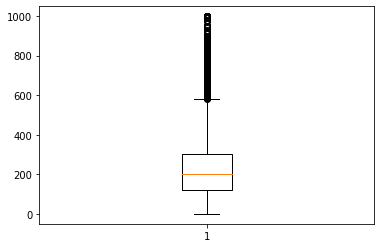

In [54]:
# outlier를 제외한 boxplot
plt.boxplot(listings.new_price[listings.new_price<1000])

(array([1.340e+02, 1.822e+03, 3.182e+03, 2.981e+03, 2.420e+03, 2.309e+03,
        1.966e+03, 1.648e+03, 1.393e+03, 8.350e+02, 6.570e+02, 5.040e+02,
        4.140e+02, 2.400e+02, 1.560e+02, 1.740e+02, 1.300e+02, 7.300e+01,
        7.900e+01, 3.500e+01, 6.400e+01, 5.100e+01, 4.100e+01, 2.900e+01,
        2.700e+01, 5.000e+01, 3.100e+01, 3.200e+01, 1.100e+01, 8.000e+00,
        8.000e+00, 1.300e+01, 9.000e+00, 7.000e+00, 4.000e+00, 3.000e+00,
        1.500e+01, 1.100e+01, 2.000e+00, 0.000e+00, 5.000e+00, 1.000e+00,
        7.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 2.000e+00]),
 array([   0.  ,   39.98,   79.96,  119.94,  159.92,  199.9 ,  239.88,
         279.86,  319.84,  359.82,  399.8 ,  439.78,  479.76,  519.74,
         559.72,  599.7 ,  639.68,  679.66,  719.64,  759.62,  799.6 ,
         839.58,  879.56,  919.54,  959.52,  999.5 , 1039.48, 1079.46,
        1119.44, 1159.42, 1199.4 , 1239.38, 1279.36, 1319.34, 1359.32,
        1399.3 , 1439

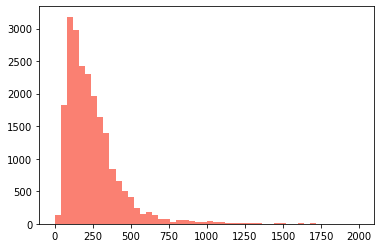

In [55]:
plt.hist(listings.new_price[listings.new_price<2000],bins=50,color='salmon')

#### 4개의 가격 그룹으로 나누어 시각화

In [142]:
ranges = [0,120,200,310,10050]
labels = ['cheap','moderate','expensive','very expensive']
pricebins = pd.cut(listings.new_price, ranges, labels=labels)
pricebins=pd.DataFrame(pricebins)
pricebins

            new_price
0           expensive
2            moderate
3      very expensive
5               cheap
6               cheap
7            moderate
8            moderate
9           expensive
10              cheap
12           moderate
...               ...
48357  very expensive
48360           cheap
48364       expensive
48366  very expensive
48367  very expensive
48368           cheap
48369           cheap
48370           cheap
48371  very expensive
48373  very expensive

[21683 rows x 1 columns]

In [161]:
listingp = listings.copy()
del listingp['new_price']
listingp.columns

Index(['id', 'host_id', 'host_listings_count', 'latitude', 'longitude', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'host_age', 'superhost_f', 'superhost_t',
       'id_verified_f', 'id_verified_t', 'Entire_home/apt', 'Hotel_room', 'Private_room',
       'Shared_room', 'instant_bookable_f', 'instant_bookable_t', 'cancel_flexible',
       'cancel_moderate', 'cancel_strict', 'cancel_strict_14_with_grace_period',
       'cancel_super_strict_30', 'cancel_super_strict_60'],
      dtype='object')

(array([3246.,  350.,  304.,  164.,  206.,   78.,  167.,  187.,  297.,
         487.]),
 array([  0. ,  36.5,  73. , 109.5, 146. , 182.5, 219. , 255.5, 292. ,
        328.5, 365. ]),
 <a list of 10 Patch objects>)

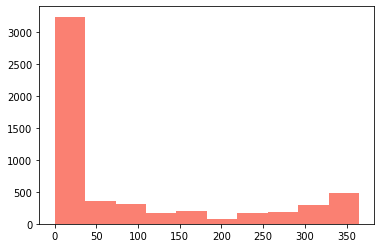

In [162]:
listingp = pd.concat([listingp, pricebins], axis=1)
cheap = listingp[listingp['new_price']=='cheap']
mod = listingp[listingp['new_price']=='moderate']
exp = listingp[listingp['new_price']=='expensive']
vex = listingp[listingp['new_price']=='very expensive']
plt.hist(cheap['availability_365'],color='salmon')

(array([3230.,  396.,  312.,  208.,  206.,   88.,  188.,  258.,  281.,
         371.]),
 array([  0. ,  36.5,  73. , 109.5, 146. , 182.5, 219. , 255.5, 292. ,
        328.5, 365. ]),
 <a list of 10 Patch objects>)

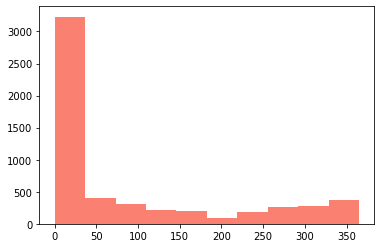

In [163]:
plt.hist(mod['availability_365'],color='salmon')


(array([2603.,  335.,  292.,  219.,  202.,  121.,  212.,  343.,  402.,
         513.]),
 array([  0. ,  36.5,  73. , 109.5, 146. , 182.5, 219. , 255.5, 292. ,
        328.5, 365. ]),
 <a list of 10 Patch objects>)

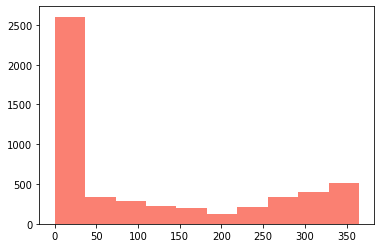

In [164]:
plt.hist(exp['availability_365'],color='salmon')


(array([1630.,  292.,  337.,  269.,  250.,  142.,  257.,  437.,  719.,
        1083.]),
 array([  0. ,  36.5,  73. , 109.5, 146. , 182.5, 219. , 255.5, 292. ,
        328.5, 365. ]),
 <a list of 10 Patch objects>)

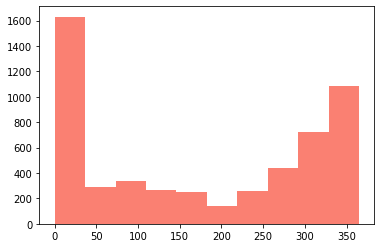

In [165]:
plt.hist(vex['availability_365'],color='salmon')

### 7. number_of_reviews

In [57]:
listings.number_of_reviews.describe()

count    21683.000000
mean        21.737121
std         43.942178
min          0.000000
25%          1.000000
50%          4.000000
75%         20.000000
max        618.000000
Name: number_of_reviews, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2710139ba58>,
 'caps': [<matplotlib.lines.Line2D at 0x2710139beb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2710139b668>],
 'medians': [<matplotlib.lines.Line2D at 0x271013a6828>],
 'fliers': [<matplotlib.lines.Line2D at 0x271013a6b70>],
 'means': []}

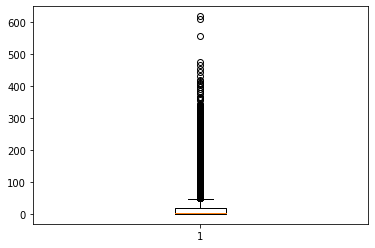

In [58]:
plt.boxplot(listings.number_of_reviews)

(array([316.,   7.,   3.,   3.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00000000e+00, 1.67666667e+02, 3.34333333e+02, 5.01000000e+02,
        6.67666667e+02, 8.34333333e+02, 1.00100000e+03, 1.16766667e+03,
        1.33433333e+03, 1.50100000e+03, 1.66766667e+03, 1.83433333e+03,
        2.00100000e+03, 2.16766667e+03, 2.33433333e+03, 2.50100000e+03,
        2.66766667e+03, 2.83433333e+03, 3.00100000e+03, 3.16766667e+03,
        3.33433333e+03, 3.50100000e+03, 3.66766667e+03, 3.83433333e+03,
        4.00100000e+03, 4.16766667e+03, 4.33433333e+03, 4.50100000e+03,
        4.66766667e+03, 4.83433333e+03, 5.00100000e+03]),
 <a list of 30 Patch objects>)

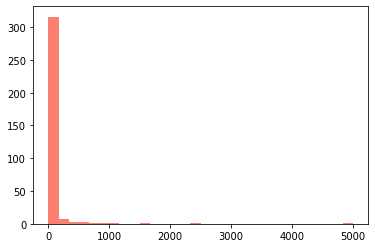

In [59]:
x = listings.number_of_reviews.value_counts()
plt.hist(x,bins=30,color='salmon')

### 8. review_score_ratings

In [60]:
listings.review_scores_rating.describe()

count    16256.000000
mean        93.505536
std          9.040010
min         20.000000
25%         91.000000
50%         96.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x271007879b0>,
 'caps': [<matplotlib.lines.Line2D at 0x27100787e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x27100787588>],
 'medians': [<matplotlib.lines.Line2D at 0x271000e5780>],
 'fliers': [<matplotlib.lines.Line2D at 0x271000e5ac8>],
 'means': []}

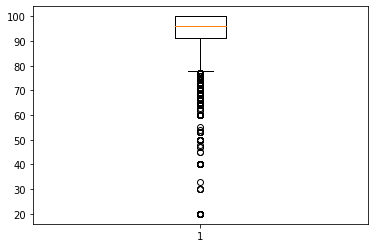

In [61]:
plt.boxplot(listings.review_scores_rating[listings.review_scores_rating.notnull()])

<BarContainer object of 51 artists>

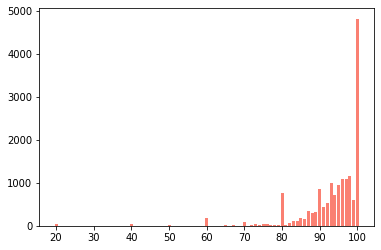

In [62]:
x = listings.review_scores_rating.value_counts()
plt.bar(x.index,x.values,color='salmon')

### 9. instant_bookable

<BarContainer object of 2 artists>

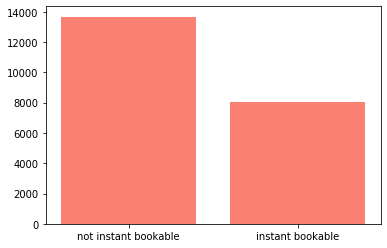

In [63]:
ind = ['not instant bookable','instant bookable']
hei = [listings.instant_bookable_f.sum(),listings.instant_bookable_t.sum()]
plt.bar(ind, hei,color='salmon')

### 10. cancellation_policy

<BarContainer object of 6 artists>

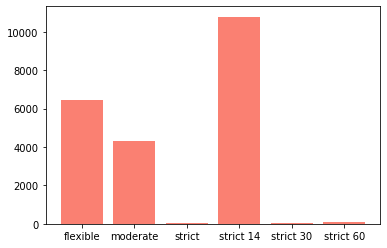

In [64]:
ind = ['flexible','moderate','strict','strict 14','strict 30','strict 60']
mod = listings.cancel_moderate.sum()
st = listings.cancel_strict.sum()
st14 = listings.cancel_strict_14_with_grace_period.sum()
st30 = listings.cancel_super_strict_30.sum()
st60 = listings.cancel_super_strict_60.sum()
hei = [listings.cancel_flexible.sum(),mod,st,st14,st30,st60]
plt.bar(ind, hei,color='salmon')

# data 조정

### 1. review_scores_rating의 null 값 : mean으로 대체

In [65]:
listings.review_scores_rating.isnull().sum() #5427
mean = listings.review_scores_rating.mean()
listings.review_scores_rating[listings.review_scores_rating.isnull()] = mean
listings.review_scores_rating.isnull().sum()

0

### 2. 4가지로 나누어져 있는 strict cancellation policy를 하나로 합침

In [66]:
strict = listings.cancel_strict

for i in range(21683):
    if listings.cancel_strict_14_with_grace_period.iloc[i] == 1:
        strict.iloc[i] = 1

for i in range(21683):
    if listings.cancel_super_strict_30.iloc[i] == 1:
        strict.iloc[i] = 1
        
for i in range(21683):
    if listings.cancel_super_strict_60.iloc[i] == 1:
        strict.iloc[i] = 1

strict

0        1
2        1
3        0
5        1
6        0
7        1
8        1
9        1
10       0
12       1
        ..
48357    1
48360    0
48364    0
48366    0
48367    1
48368    0
48369    0
48370    0
48371    0
48373    0
Name: cancel_strict, Length: 21683, dtype: int64

In [67]:
strict.sum()

10935

In [68]:
listings.cancel_strict = strict
listings.head()

     id  host_id  host_listings_count  latitude  longitude  availability_365  number_of_reviews  \
0  3647     4632                  1.0  40.80902  -73.94190               365                  0   
2  5022     7192                  1.0  40.79851  -73.94399                 0                  9   
3  5099     7322                  1.0  40.74767  -73.97500                13                 75   
5  5178     8967                  1.0  40.76489  -73.98493               246                443   
6  5203     7490                  1.0  40.80178  -73.96723                 0                118   

   review_scores_rating  host_age  superhost_f  ...  Shared_room  new_price  instant_bookable_f  \
0             93.505536    3943.0            1  ...            0        225                   1   
2             93.000000    3878.0            1  ...            0        160                   1   
3             89.000000    3874.0            1  ...            0        325                   1   
5        

<BarContainer object of 3 artists>

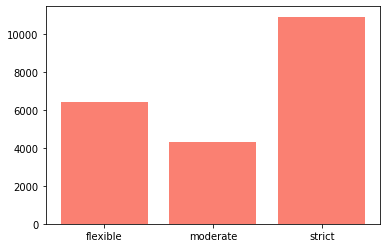

In [69]:
# 분포 확인
ind = ['flexible','moderate','strict']
mod = listings.cancel_moderate.sum()
st = listings.cancel_strict.sum()
hei = [listings.cancel_flexible.sum(),mod,st]
plt.bar(ind, hei,color='salmon')

(array([2506.,  321.,  250.,  150.,  148.,   79.,  142.,  164.,  229.,
         333.]),
 array([  0. ,  36.5,  73. , 109.5, 146. , 182.5, 219. , 255.5, 292. ,
        328.5, 365. ]),
 <a list of 10 Patch objects>)

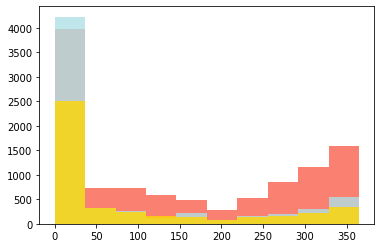

In [70]:
fle = listings[listings['cancel_flexible']==1]
mode = listings[listings['cancel_moderate']==1]
stri = listings[listings['cancel_strict']==1]
plt.hist(stri['availability_365'],color='salmon')
plt.hist(fle['availability_365'],color='powderblue', alpha=0.8)
plt.hist(mode['availability_365'],color='gold',alpha=.8)

In [71]:
# 필요없는 열 제거
del listings['cancel_strict_14_with_grace_period']
del listings['cancel_super_strict_30']
del listings['cancel_super_strict_60']
listings.columns

Index(['id', 'host_id', 'host_listings_count', 'latitude', 'longitude', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'host_age', 'superhost_f', 'superhost_t',
       'id_verified_f', 'id_verified_t', 'Entire_home/apt', 'Hotel_room', 'Private_room',
       'Shared_room', 'new_price', 'instant_bookable_f', 'instant_bookable_t', 'cancel_flexible',
       'cancel_moderate', 'cancel_strict'],
      dtype='object')

# 변수간 상관관계 분석

In [72]:
# 필요없는 열을 제거한 새로운 데이터프레임 생성
listingreg = listings.copy()
del listingreg['id']
del listingreg['host_id']
del listingreg['latitude']
del listingreg['longitude']
del listingreg['superhost_f']
del listingreg['id_verified_f']
del listingreg['Entire_home/apt']
del listingreg['cancel_flexible']
del listingreg['instant_bookable_f']
listingreg.columns

Index(['host_listings_count', 'availability_365', 'number_of_reviews', 'review_scores_rating',
       'host_age', 'superhost_t', 'id_verified_t', 'Hotel_room', 'Private_room', 'Shared_room',
       'new_price', 'instant_bookable_t', 'cancel_moderate', 'cancel_strict'],
      dtype='object')

In [73]:
cor = listingreg.corr()
cor

                      host_listings_count  availability_365  number_of_reviews  \
host_listings_count              1.000000          0.268895          -0.098327   
availability_365                 0.268895          1.000000           0.136184   
number_of_reviews               -0.098327          0.136184           1.000000   
review_scores_rating            -0.005280         -0.080409           0.027068   
host_age                        -0.098463         -0.172176           0.186600   
superhost_t                      0.070937          0.158640           0.275226   
id_verified_t                   -0.089401         -0.132452           0.121711   
Hotel_room                       0.004784          0.144387          -0.030257   
Private_room                    -0.156076         -0.092914           0.110993   
Shared_room                     -0.030658          0.023947           0.003433   
new_price                        0.085928          0.161636          -0.063995   
instant_bookable

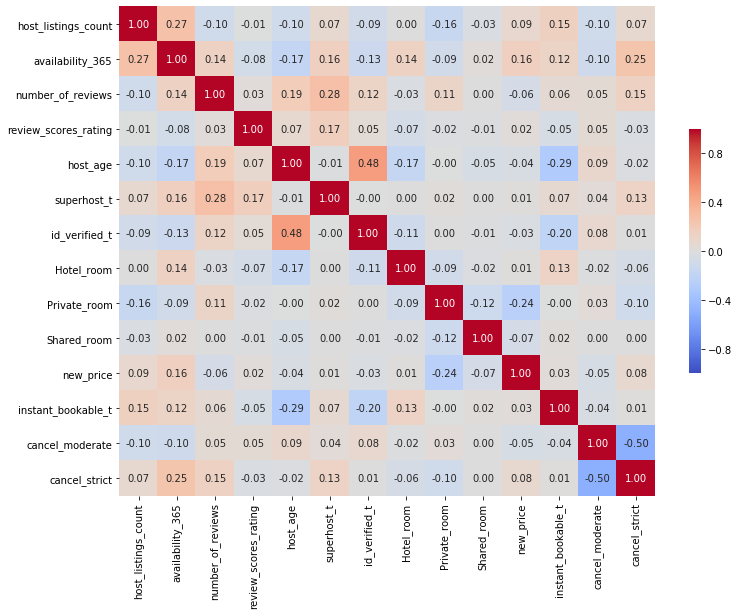

In [74]:
# 히트맵 확인
plt.figure(figsize=(12,9))
sns.heatmap(data = cor, vmin=-1,annot=True, fmt = '.2f', cmap='coolwarm', cbar_kws={"shrink":.5})

# 다중회귀분석

In [75]:
# 모델 생성
model = smf.ols(formula = 'availability_365 ~ host_listings_count+number_of_reviews+review_scores_rating+host_age+superhost_t+id_verified_t+Hotel_room+Private_room+Shared_room+new_price+instant_bookable_t+cancel_moderate+cancel_strict' , 
                data = listingreg)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       availability_365   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     465.8
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:27:43   Log-Likelihood:            -1.3437e+05
No. Observations:               21676   AIC:                         2.688e+05
Df Residuals:                   21662   BIC:                         2.689e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              202.9140     10.159     19.975      0.000     183.003     222.825
host_listings_count      0.2207      0.006     37.933      0.000       0.209       0.232
number_of_reviews        0.4504      0.020     22.258      0.000       0.411       0.490
review_scores_rating    -1.3085      0.106    -12.380      0.000      -1.516      -1.101
host_age                -0.0180      0.001    -15.723      0.000      -0.020      -0.016
superhost_t             29.1783      2.309     12.638      0.000      24.653      33.704
id_verified_t          -15.6171      1.862     -8.386      0.000     -19.267     -11.967
Hotel_room             138.9655      6.793     20.457      0.000     125.650     152.281
Private_room            -2.6643      1.801     -1.479      0.139      -6.195       0.867
Shared_room             29.9357      5.486      5.456      0.000      19.182      40.689
new_price                0.0506      0.002     20.766      0.000       0.046       0.055
instant_bookable_t       0.4689      1.796      0.261      0.794      -3.051       3.989
cancel_moderate         14.7772      2.400      6.157      0.000      10.073      19.481
cancel_strict           56.8417      1.954     29.085      0.000      53.011      60.672
==============================================================================
Omnibus:                     1696.739   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2072.468
Skew:                           0.747   Prob(JB):                         0.00
Kurtosis:                       2.744   Cond. No.                     2.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
# 다중공선성 확인
y, X = dmatrices('availability_365 ~ host_listings_count+number_of_reviews+review_scores_rating+host_age+superhost_t+id_verified_t+Hotel_room+Private_room+Shared_room+new_price+instant_bookable_t+cancel_moderate+cancel_strict', listingreg, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

    VIF Factor              features
0   157.541835             Intercept
1     1.083832   host_listings_count
2     1.207044     number_of_reviews
3     1.045044  review_scores_rating
4     1.451237              host_age
5     1.150933           superhost_t
6     1.316351         id_verified_t
7     1.062518            Hotel_room
8     1.142286          Private_room
9     1.031495           Shared_room
10    1.080011             new_price
11    1.147247    instant_bookable_t
12    1.403804       cancel_moderate
13    1.457611         cancel_strict

# 위치 확인

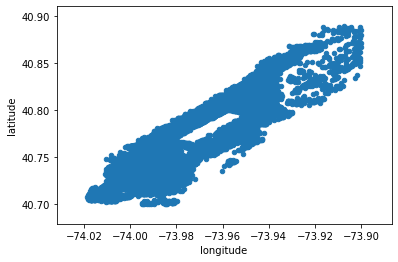

In [77]:
listings.plot.scatter(x='longitude',y='latitude')

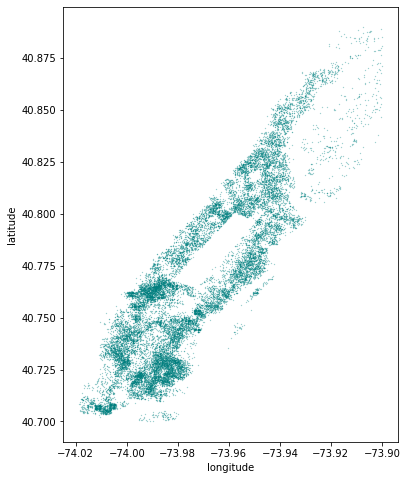

In [78]:
plot = listings.plot(kind="scatter", x="longitude", y="latitude",c='teal',s=0.07,alpha=0.6,figsize=(6,8))
plt.show()

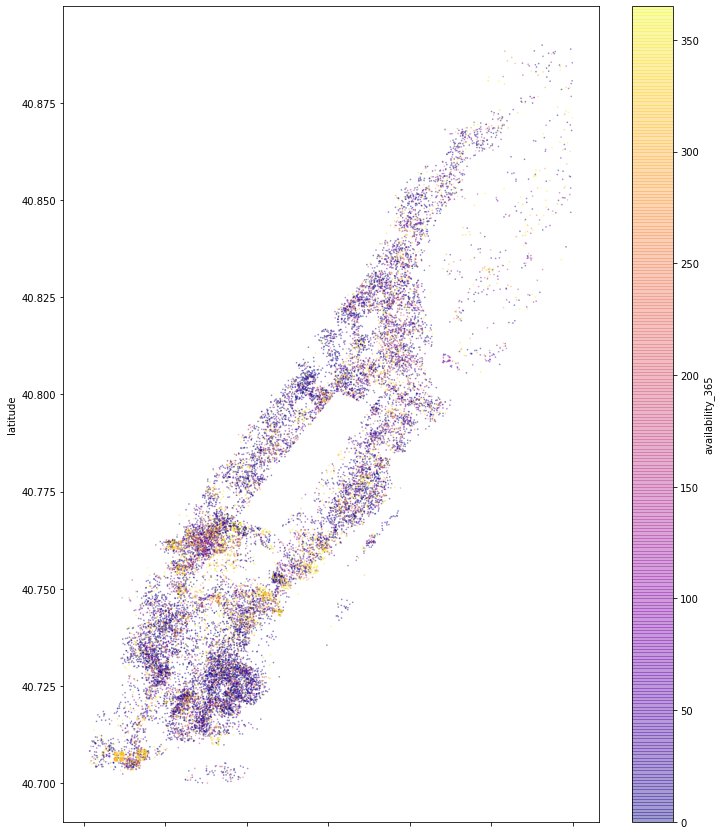

In [79]:
plot = listings.plot(kind="scatter", x="longitude", y="latitude",c="availability_365", s=0.5,alpha=0.4,cmap='plasma',figsize=(12,15))
plt.show()